<h1>Data Driven Business: Data Science pipeline.</h1>

Om nuttige voorspellingen te doen, moet eerst bepaald worden wat voorspeld moet worden. Dit document in bedoelt om later in het hoofd-document in integreren, maar is voor nu stand-alone, en dekt de Business-Understanding, Data-Understanding en (gedeeltelijk) Data-Preparation voor het target variabele af.

<h2>Target variabele.</h2>

<h3>Business understanding</h3>

Door de interviews met onze business-expert hebben begrepen dat het voorspellen van moment van 'functieherstel' toegevoegde waarde voor ProRail zou hebben. Dit is het moment dat een traject weer klaar is om treinverkeer toe te staan. Via ProRail hebben wij dit diagram aangeleverd gekregen, wat inzicht geeft in het bedrijfsprocess:

![title](images/badkuip.png)
De X-as beslaat tijd, en de Y-as hoeveelheid treinverkeer (beiden non-proportioneel). Dit model zal naar gerefereerd worden als 'badkuip model'.

Functieherstel staat niet expliciet benoemd in dit model, maar vind plaats in de buurt van het "Storing-Eind" moment, en wanneer de lijn weer omhoog begint te bewegen op de Y-as.

ProRail baat bij een goede voorspelling wat betreft moment van functieherstel, zodat ze kunnen zorgen dat het opstarten van de dienstregeling zo goed mogelijk hierop kan aansluiten.

Uit de interviews blijkt dat de gegevens die waarschijnlijk tot een goede prognose leiden waarschijnlijk pas beschikbaar zijn wanneer een aannemer ter plekke is, in het badkuipmodel benoemd als "oplosteam aanwezig". Als het goed is zijn zowel het tijdstip van aankomst van de monteur, als het tijdstip van functieherstel aanwezig in de dataset, hoewel dit later in 'Data Understanding' bevestigd moet worden.

De verstreken tijd tussen de melding van een incident, en het moment dat een oplosteam aanwezig is is sterk variabel. Hoewel dit in de toekomst wellicht ook te voorspellen zou zijn met een model, beperken wij in onze huidige aanpak tot het voorspellen van 'aankomst aannemer' tot 'functieherstel', omdat dat volgens onze huidige business-kennis het best voorspelbaar is aan de hand van de attributen van een specifieke storing.

<h3>Data Understanding.</h3>

Om de mogelijkheid van het implementeren van het targetvariabele van (tijdstip functieherstel) - (tijdstip aankomst aannemer) te onderzoeken, moet de data geïnspecteerd om te bepalen of dit ook echt realistisch is. Hiervoor onderzoeken we de eerder benoemde hypothese voor targetvariabele, en eventuele variabelen die hier concurrentie voor zouden kunnen zijn, of meer inzicht zouden kunnen geven.

We beginnen met het importeren van een aantal libraries, en de dataset:

In [1]:
import enum
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import dummy
from sklearn import linear_model
from sklearn import model_selection
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("sap_storing_data_hu_project.csv", low_memory=True)
df

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,...,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,2014,07/05/2014 05:30:12,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,34415,3617016,07/05/2014 05:44:24,0
1,1,50053211,0.0,NaN,02/01/2006 09:00:00,02/01/2006 09:00:00,Logboeknr Geeltje : 49 Tijd: 0900 VL-Po...,NaN,Logboeknr Geeltje : 49 Tijd: 0900,NaN,...,1,2006,02/01/2006 09:00:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,1518,12704590,13/06/2013 13:37:52,0
2,2,50053213,48.0,GN,02/01/2006 12:35:00,02/01/2006 12:35:00,Logboeknr RBV : 48 Tijd: 1235 VL-Post: ...,02/01/2006 12:35:00,Logboeknr RBV : 48 Tijd: 1235 VL-P,NaN,...,1,2006,02/01/2006 12:35:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,1518,12704591,13/06/2013 13:37:52,0
3,3,50053214,72.0,ZL,02/01/2006 16:40:00,02/01/2006 16:40:00,Logboeknr RBV : 72 Tijd: 1640 VL-Post: ...,02/01/2006 16:40:00,Logboeknr RBV : 72 Tijd: 1640 VL-P,NaN,...,1,2006,02/01/2006 16:40:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,1518,12704592,13/06/2013 13:37:52,0
4,4,50053215,96.0,ZL,02/01/2006 22:30:00,02/01/2006 22:30:00,Logboeknr RBV : 96 Tijd: 2230 VL-Post: ...,02/01/2006 22:30:00,Logboeknr RBV : 96 Tijd: 2230 VL-P,NaN,...,1,2006,02/01/2006 22:30:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,1518,12704593,13/06/2013 13:37:52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898521,908625,99003505,0.0,NaN,11/05/2013 08:06:00,11/05/2013 08:06:00,GVC : sp-2 en 3 stop lampen op de stootjukke...,NaN,GVC : sp-2 en 3 stop lampen op de stoot,NaN,...,8,2013,05/08/2013 01:00:16,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,3344,12759543,05/08/2013 01:30:37,0
898522,908626,99003506,0.0,NaN,11/05/2013 09:21:00,11/05/2013 09:21:00,Whz : Ovw 100.1 albert Plesmanweg blijft dic...,NaN,Whz : Ovw 100.1 albert Plesmanweg blijft,NaN,...,5,2013,11/05/2013 09:21:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,05/08/2013 01:00:16,0,1518,12759544,13/06/2013 13:37:52,0
898523,908627,99003506,0.0,NaN,11/05/2013 09:21:00,11/05/2013 09:21:00,Whz : Ovw 100.1 albert Plesmanweg blijft dic...,NaN,Whz : Ovw 100.1 albert Plesmanweg blijft,NaN,...,8,2013,05/08/2013 01:00:16,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,3344,12759544,05/08/2013 01:30:37,0
898524,908628,99999999,0.0,NaN,20/08/2016 14:15:17,20/08/2016 14:15:17,Bdg-Apn : Km 12.7 twee gedode zwanen langs het...,NaN,Bdg-Apn : Km 12.7 twee gedode zwanen lan,NaN,...,8,2016,23/08/2016 06:00:19,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,24/10/2016 06:00:11,0,450213,3710373,01/09/2016 06:09:38,0


Omdat de dataset redelijk groot is, kosten veel van de operaties die tijdens het verkennen van de data gebeuren, erg veel tijd. Volgens onze business-expert zou een willikeurige selectie van ongeveer 10% van de dataset alsnog representatief voor de hele dataset moeten zijn, dus voor het verkennen maken we dit meteen aan.

In [3]:
sample = df.sample(frac=0.1, random_state=1)

Iets interessants om te onderzoeken is de relatie tussen de tijdstippen van functieherstel, storing eind, en tijdstip van melding. We maken voor de onderzoek doeleinden hier aparte variabelen van voor gemak, en kijken naar de datatypes.

In [4]:
fh_tijdstip = sample["stm_fh_ddt"]
stor_eind = sample["stm_sap_storeind_ddt"]
stm_sap_meld_ddt = sample["stm_sap_meld_ddt"]

In [5]:
print(f"""{fh_tijdstip.dtype}
{stor_eind.dtype}
{stm_sap_meld_ddt.dtype}""")

object
object
object


Al deze kolommen bestaan uit Strings. Deze moeten omgezet worden naar DateTime voor effectief rekenwerk. Hierna slaan we ze op in een apart DataFrame voor onderzoek. Uit dit dataframe verwijderen we alle rijen waar minimaal 1 NaN waarde instaat, omdat dit dataframe bedoelt is om de werking tussen de verschillende kolommen te vergelijken.

Ook definieren we een TimeDelta object voor 2 minuten, omdat het exact vergelijken van tijdstippen voor onze doelen vaak niet nuttig is, en als dingen binnen 2 minuten van elkaar vallen, dit in veel gevallen meer informatie kan geven.

In [6]:
fh_tijdstip = pd.to_datetime(fh_tijdstip, errors="coerce")
stor_eind = pd.to_datetime(stor_eind, errors="coerce")
stm_sap_meld_ddt = pd.to_datetime(stm_sap_meld_ddt, errors="coerce")

twominutes = pd.to_timedelta(2, unit="m")

In [7]:
#sample_de_1 = DataFrame DataExploration 1
df_de_1 = pd.DataFrame({"fh_ddt": fh_tijdstip,
                       "se_ddt": stor_eind,
                       "meld_ddt": stm_sap_meld_ddt}).dropna()

df_de_1.shape  # 1/3rd is dropped from nas

(66036, 3)

Een eerste vraag om te onderzoek is naar het verschil tussen "Storing eind" en "Functieherstel". Uit ons business-onderzoek begrijpen we dat deze waarschijnlijk de volgende betekenissen hebben:

Functieherstel: Het moment dat er theoretisch weer treinverkeer over het traject kan.
Storing eind: Wanneer het probleem opgelost is, en de herstelwerkzaamheden voltooid zijn.

Omdat het probleem vaak opgelost is, wanneer er weer treinen over het traject kunnen, zullen deze 2 momenten vaak tegelijk zijn. Dit kunnen we ook bevestigen:

In [8]:
def percentage(numerator: float, denominator: float) -> float:
    """Calculate a percentage from a fraction.

    Args:
        numerator: fraction numerator.
        denominator: fraction denominator.

    Returns:
        Percentage between 0 and 100, as float."""
    return (numerator / denominator) * 100


n_fh_is_se = (np.abs(df_de_1["fh_ddt"] - df_de_1["se_ddt"]) < twominutes).sum()
f"Storing Eind is in {percentage(n_fh_is_se, df_de_1.shape[0])}% van de gevallen binnen 2 minuten van Functie Herstel."

'Storing Eind is in 45.60997031921982% van de gevallen binnen 2 minuten van Functie Herstel.'

In veel andere gevallen zou men verwachten dat storing eind na functieherstel is, wanneer de aannemer het spoor weer operationeel krijgt, maar daarna wel nog werk moet afmaken.

In [9]:
n_fh_voor_se = ((df_de_1["se_ddt"] - twominutes) > df_de_1["fh_ddt"]).sum()
f"Storing eind is in {percentage(n_fh_voor_se, df_de_1.shape[0])}% van de gevallen meer dan 2 minuten na functieherstel."

'Storing eind is in 47.62553758555939% van de gevallen meer dan 2 minuten na functieherstel.'

Dit correspondeerd met de verwachting van Business Understanding.

Eerder hebben wij op basis van businesskennis een belovend targetvariabele vastgesteld, namelijk het verschil in tijd tussen het arriveren van de aannemer, en functieherstel. Om dit daadwerkelijk te kunnen gebruiken moet de daadwerkelijke data die hieraan correspondeerd geïnspecteerd worden.

In de data dictionairy staan specifiek een kolom voor datum en tijd (apart) benoemd voor het arriveren van de aannemer, namelijk "stm_aanntpl_dd" voor datum en "stm_aanntpl_tijd" voor tijd. In de dataset zit ook een kolom "stm_aanntpl_ddt", hoewel deze in de dictionairy als n.v.t. bestempeld is. Toch lijkt het nuttig het verschil tussen deze kolommen even te inspecteren, om te kijken welke van deze het beste is.

Ten eerste is het handig een beeld te hebben hoeveel NaN waardes er in deze kolommen zitten.

In [10]:
n_nan_aanntpl_dd = sample["stm_aanntpl_dd"].isna().sum()
f"De datumkolom bestaat voor {percentage(n_nan_aanntpl_dd, sample.shape[0])}% uit NaN waardes."

'De datumkolom bestaat voor 23.01759540582952% uit NaN waardes.'

In [11]:
n_nan_aanntpl_tijd = sample["stm_aanntpl_tijd"].isna().sum()
f"De tijdkolom bestaat voor {percentage(n_nan_aanntpl_tijd, sample.shape[0])}% uit NaN waardes."

'De tijdkolom bestaat voor 0.0022258577899458% uit NaN waardes.'

In [12]:
n_nan_aanntpl_ddt = sample["stm_aanntpl_ddt"].isna().sum()
f"De gecombineerde datum en tijdkolom bestaat voor {percentage(n_nan_aanntpl_dd, sample.shape[0])}% uit NaN waardes."

'De gecombineerde datum en tijdkolom bestaat voor 23.01759540582952% uit NaN waardes.'

De hoeveelheid NaN waardes komt overeen tussen de dd en ddt kolommen. Om te bevestigen dat deze gelijk zijn kunnen we de datum en tijd kolommen combineren naar één, en ze allemaal als DateTime objecten in een apart DataFrame zetten.

In [13]:
ddt_format = sample["stm_aanntpl_dd"] + " " + sample["stm_aanntpl_tijd"]

df_aan = pd.DataFrame({"t": pd.to_datetime(sample["stm_aanntpl_tijd"], errors="coerce"),
                       "d": pd.to_datetime(sample["stm_aanntpl_dd"], errors="coerce"),
                       "dt": pd.to_datetime(sample["stm_aanntpl_ddt"], errors="coerce"),
                       "dt_own": pd.to_datetime(ddt_format, errors="coerce")}).dropna()


In [14]:
f"In {percentage((df_aan['dt'] == df_aan['dt_own']).sum(), df_aan.shape[0])}% van de non-NaN gevallen is de ddt kolom gelijk aan aan de datum en tijd kolom."

'In 100.0% van de non-NaN gevallen is de ddt kolom gelijk aan aan de datum en tijd kolom.'

Al met al kunnen we dus net zo goed de ddt_tabel in de originele dataset gebruiken als targetvariabele.

Dan nog even kijken of er idd genoeg nuttige entries zijn voor functieherstel - arrival monteur

In [15]:
possible_target = df_de_1["fh_ddt"] - df_aan["dt"]  # Tijdstip functieherstel - tijdstip aankomst aannemer.
f"De mogelijke target bestaat voor {percentage(possible_target.isna().sum(), possible_target.shape[0])}% uit NaN-waardes."

'De mogelijke target bestaat voor 15.889250548163483% uit NaN-waardes.'

In [16]:
possible_target.dropna(inplace=True)
f"Wanneer deze NaN-waardes worden weggelaten hou je van de originele dataset uiteindelijk ongeveer {percentage(possible_target.shape[0], sample.shape[0])}% over die een targetvariabele hebben."

'Wanneer deze NaN-waardes worden weggelaten hou je van de originele dataset uiteindelijk ongeveer 68.73448855352632% over die een targetvariabele hebben.'

Om een nuttig targetvariabele te creeëren, zouden we uiteindelijk alle TimeDelta objecten die we gecreeërd hebben omzetten naar de hoeveelheid seconden waaruit dit tijdsinterval bestaat. Hoewel rekenen in seconden het inzicht mogelijk moeilijker maakt, verhoogt dit wel de granulariteit van het targetvariabele, waardoor deze zich meer gedraagd als continue waarde, wat de performance van het model weer ten goede komt. Om inzicht te verbeteren in performance, definieren we voor het gemak wel even een functie die een seconden-series naar minuten omzet, zodat grafieken leesbaarder gemaakt kunnen worden.

In [17]:
class TimeUnit(enum.Enum):
    """Enum that represents a unit of measurement of time, to enable easy conversion from one unit to another.

    Values for units of measurements are measured in seconds."""
    second = 1
    minute = 60
    hour = 60 * 60
    day_night_cycle = 60 * 60 * 24


def convert_timeunit(value: pd.Series or float or int,
                     from_type: TimeUnit,
                     to_type: TimeUnit) -> float:
    """Convert an amount of time as number, or a series of those, to another.

    Not class attribute of TimeUnit class to allow for better typing.

    Args:
        value:
            a number, or a series of numbers, that represent an amount of time in a certain unit of measurement as defined in
            TimeUnit.
        from_type: TimeUnit scale of measurement of time that input is in.
        to_type: TimeUnit scale of measurement of time that output should be in.

    Returns:
        Time measurement(s) converted to new unit of measurement.
        Scalar if input was scalar, array/series of input type if input was array/series."""
    coef = from_type.value / to_type.value
    return value * coef

We creeëren voor nu een apart variabele voor het targetvariabele als seconden. Deze bevat mogelijk een aantal 0-waarden, laten we deze eerst inspecteren.

In [18]:
de_target_secs = possible_target.dt.total_seconds()
f"Het targetvariabele bestaat voor {percentage((de_target_secs == 0).sum(), de_target_secs.shape[0])}% uit 0 seconden."

'Het targetvariabele bestaat voor 2.5922927461139897% uit 0 seconden.'

Het is wellicht interessant een beeld te hebben van outliers van ons targetvariabele:

{'whiskers': [<matplotlib.lines.Line2D at 0x21fa3d89bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x21fa402c2b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x21fa3d89820>],
 'medians': [<matplotlib.lines.Line2D at 0x21fa402c970>],
 'fliers': [<matplotlib.lines.Line2D at 0x21fa402ccd0>],
 'means': []}

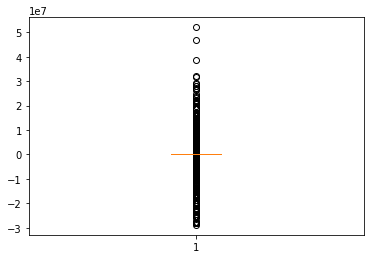

In [19]:
plt.boxplot(de_target_secs)

Uit deze bijna-onleesbare boxplot blijkt dat vooral boven de bovengrens, er heel veel extreme outliers zijn. Aan de onderkant zijn er ook een aantal negatieve waarden. Als we er vanuit gaan dat dit niet door foutive data word veroorzaakt, betekend dit waarschijnlijk dat er al weer treinen kunnen rijden, voordat er uberhaupt een monteur aan te pas komt. Hier moet wat aan gedaan worden.

Een standaardmethode om outliers te verwijderen, is de interkwartielafstand(<i>IQR</i>) berekenen, en alle waarnemingen 3IQR boven het 3e kwartiel, en 3IQR onder het eerste kwartiel te verwijderen. Het lijkt ons echter verstandiger in dit geval het verwijderen van outliers te baseren op business-kennis.

Om een nuttig voorspellend model te maken, is het waarschijnlijk handig om een ondergrens in functiehersteltijd te stellen vanaf het moment dat de aannemer komt. Omdat wij inschatten dat bij storingen onder de 5 minuten de aannemer zelf ook kan inschatten dat het heel kort gaat duren, en een voorspelling hier waarschijnlijk niet nuttig is, laten we deze weg uit onze dataset.

Onze business-expert heeft aangegeven alle hersteltijden boven de 6u niet interessant te vinden, dus deze waarnemingen laten we als NaN waarde in ons targetvariabele, en maken we een aparte binaire-categorie kolom voor, zodat dit eventueel in de toekomst nog gebruikt kan worden voor een apart model.

Om de verdelingen voor het eerste model te kunnen onderzoeken, halen we bij de data-exploration set nu alles onder 5 minuten en boven 6 uur eruit.



In [20]:
de_target_secs = de_target_secs.loc[(de_target_secs < convert_timeunit(6, TimeUnit.hour, TimeUnit.second)) & (de_target_secs > convert_timeunit(5, TimeUnit.minute, TimeUnit.second))]

<AxesSubplot:>

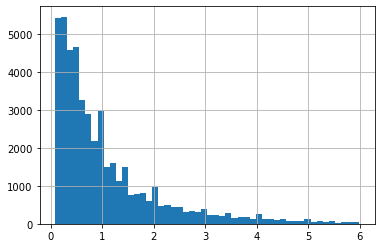

In [21]:
(convert_timeunit(de_target_secs, TimeUnit.second, TimeUnit.hour)).hist(bins=50)

Ons targetvariabele lijkt exponentieel verdeeld te zijn.

Hiernaast definiëren we wel een functie die outliers op de klassieke wijze verwijderd, voor gebruik later.

In [22]:
def remove_outliers(s: pd.Series, fence: float = 3) -> pd.Series:
    """Remove the outliers from a Pandas series by removing all values that lie below q1 or above q3 with
    the product of the inter quartile distance and the 'fence'.

    Args:
        s: Series to remove outliers from.
        fence: amount of IQRs value should lie above q3 or below q1 with to get designated an outlier.

    Returns:
        Series without outliers."""
    q1, q3 = s.quantile(.25), s.quantile(.75)
    iqr = q3 - q1
    fence_iqr_prod = fence * iqr
    return s.loc[(s > q1 - fence_iqr_prod) & (s < q3 + fence_iqr_prod)]

<h3>Data preperation.</h3>

Nu we een idee hebben van een (hopelijk) bruikbaar target variabele, kunnen de benodigde operaties op de originele dataset uitgevoerd worden, om hieruit een volledig uitgewerkt targetvariabele voor later gebruik uit te creeëren.

We beginnen door de 2 benodigde kolommen voor het target variabele naar DateTime objecten te veranderen in nieuwe kolommen.

In [23]:
df["stm_aanntpl_ddt_as_pddt"] = pd.to_datetime(df["stm_aanntpl_ddt"], errors="coerce")
df["stm_fh_ddt_as_pddt"] = pd.to_datetime(df["stm_fh_ddt"], errors="coerce")

Hierna maken we een aparte kolom in de dataframe van het tijdstip van functieherstel, min tijdstip van arriveren van de monteur.

In [24]:
df["fh_min_aanntpl"] = df["stm_fh_ddt_as_pddt"] - df["stm_aanntpl_ddt_as_pddt"]

We slaan van deze nieuwe kolom het verschil op als seconden in een apart variabele.

In [25]:
target = df["fh_min_aanntpl"].dt.total_seconds()

We laten hieruit alles boven de 6 uur, en alles onder de 5 minuten weg, en slaan dit op in een nieuwe variabele.

In [26]:
boven_5_min = target > convert_timeunit(5, TimeUnit.minute, TimeUnit.second)
onder_6_uur = target < convert_timeunit(6, TimeUnit.hour, TimeUnit.second)

target = target.loc[boven_5_min & onder_6_uur]  # Gemeten in seconden.

target.head(5)

32099    2400.0
60682     900.0
60683     900.0
84560     319.0
84561     319.0
Name: fh_min_aanntpl, dtype: float64

<h3>Modelling</h3>

Met een volledig voorbereid targetvariabele, kan er een 'BaseLine' model gemaakt worden, om een RMSE score vast te stellen die overtrefd kan worden. De meest logische strategie hiervoor is het gemiddelde gokken van alle bekende waardes. Hiervoor gebruiken we van SciKitLearn de DummyRegressor, met de 'mean' strategie.

In [27]:
baseline = dummy.DummyRegressor(strategy="mean")
baseline_X = np.arange(target.shape[0])  # Dummy feature variabelen voor BaseLine.
baseline.fit(np.arange(target.shape[0]), target)

DummyRegressor()

Van dit baseline model kunnen we vervolgens de RMSE score in seconden bepalen.

In [28]:
baseline_rmse = metrics.mean_squared_error(target, baseline.predict(baseline_X), squared=False)
baseline_rmse

3904.8925801884657

Voor inzicht is het ook wel interessant deze score even in minuten te bekijken, omdat dit toch meer inzicht geeft in de business-context.

In [29]:
convert_timeunit(baseline_rmse, TimeUnit.second, TimeUnit.minute)

65.08154300314109

Dit model slaan we op in een DataFrame, waar later ook andere modellen in opgeslagen kunnen worden, zodat deze overzichtelijk bekeken kunnen worden.

In [30]:
models = pd.DataFrame({"Title": ["BaseLine model with mean strategy"],
                       "Model": [baseline],
                       "RMSE": [baseline_rmse]})

models

,Title,Model,RMSE
0,BaseLine model with mean strategy,DummyRegressor(),3904.89258


<h2>Feature variabelen: model 1</h2>

<h2>Business understanding</h2>

Uit onze interviews met ProRail blijken dat een aantal variabelen die waarschijnlijk in de Dataset te vinden zijn, van significante invloed zijn op ons targetvariabele. Dit zijn:

<ul>
<li>Type storing</li>
<li>Tijdstip op de dag</li>
<li>Dag in het jaar</li>
<li>Inschatting treinverkeersleider</li>
<li>Inschatting aannemer</li>
<li>Monitoringscode</li>
<li>Gebied</li>
</ul>

Met als doel deze variabelen uiteindelijk in een model te gebruiken. We zullen van het CRISP-DM process per variabele de Data-Understanding en Data-Preperation stappen behandelen, met waar relevant Business-Understanding.
Per featurevariabele:

<h3>Monitorings informatie</h3>

Zoals eerder in het document is genoemd is, zou informatie vanuit de monitoring nuttig kunnen zijn voor een voorspellend model.

Hier gaan we dit onderzoeken.

Vanuit business understanding weten we dat alleen de monitorings code relevant is, dus we gaan hier onderzoeken welke kolommen dat zijn.


In de data dictionairy hebben 2 kolommen gevonden die mogelijk relevant zijn, namelijk: 'stm_scenario_mon' & 'stm_mon_nr__statuscode'.

We zullen nu kijken hoeveel NA's deze kolommen bevatten.

In [31]:
df[['stm_mon_nr__statuscode', 'stm_scenario_mon']].isna().sum()

stm_mon_nr__statuscode    571685
stm_scenario_mon          862111
dtype: int64

Aantal NA's per kolom:

<ul>
<li>stm_mon_nr__statuscode   = 571685</li>
<li>stm_scenario_mon         = 862111</li>
</ul>

Hier uit kunnen we concluderen dat de kolom 'stm_scenario_mon' niet bruikbaar is. Deze kolom bevat simpelweg te veel NA's om mee te werken.

We zullen nog wel verder onderzoek doen op de kolom 'stm_mon_nr__statuscode'.

We zullen nu kijken naar het aantal unieke waarde in de kolom.

In [32]:
df['stm_mon_nr__statuscode'].nunique()

9

Nu weten we dat de kolom 9 unieke waardes bevat.  (10 als je NAN zou includen)

Dit is een fijn aantal om mee te werken.

Nu zullen we een boxplot maken waarin de verschillende monitoring statuscodes worden geplot tegenover het target variabele.

Dit zal ons inzicht geven in het invloed per category van monitoring statuscode.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


<AxesSubplot:xlabel='stm_mon_nr__statuscode', ylabel='target'>

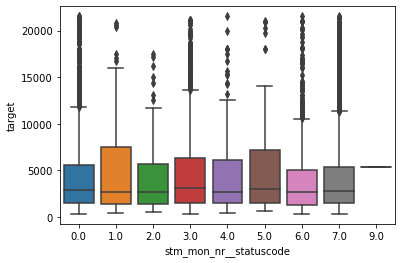

In [33]:
mon_code_col = np.array(["stm_mon_nr__statuscode"])
mon_code = sample[mon_code_col].astype("category")
mon_code["target"] = target

sns.boxplot(x=mon_code["stm_mon_nr__statuscode"], y=mon_code["target"])

In deze boxplot is te zien dat de mediaan van alle categorieen relatief dichtbij elkaar zitten. Van de hoogste tot laagste mediaan is het verschil maximaal rond de 1000 seconden.

Voor nu concluderen wij dat deze data niet genoeg invloed zal hebben op onze target. Mogelijk komen we hier later nog op terug als ons model meer data vereist.

<h3>Tijdst op de dag, en dag in het jaar.</h3>

Hier gaan we de data uit kolom 'stm_sap_meld_ddt' bruikbaar maken voor toekomstige modellen.
Dit doen we door de datetime om te zetten naar zowel: aantal secondes vanaf middernacht & dag in het jaar

Als eerst converten we stm_sap_meld_ddt naar een pandas datetime datatype. Deze kolom krijgt de naam: 'stm_sap_meld_ddt_as_pddt'.
Op deze manier hebben we de originele data, en de omgezette data beschikbaar.

In [34]:
df['stm_sap_meld_ddt_as_pddt'] = pd.to_datetime(df["stm_sap_meld_ddt"], errors="coerce")

Nu we een kolom hebben die in het pandas datetime datatype staat, kunnen we er gemakkelijk mee werken.

We gaan hier 2 kolomen aan df toevoegen, namelijk:
- stm_sap_meld_sec_mn:  Hierin staat het aantal secondes vanaf  00:00  tot het moment van de melding
- stm_sap_meld_day_count:  Hierin staat de hoeveelste dag in dat jaar het is, op het moment van de melding

In [35]:
df['stm_sap_meld_sec_mn'] = (df['stm_sap_meld_ddt_as_pddt'] - df['stm_sap_meld_ddt_as_pddt'].dt.normalize()) / pd.Timedelta(seconds=1)
df['stm_sap_meld_day_count'] = df["stm_sap_meld_ddt_as_pddt"].dt.day_of_year

Deze kunnen samen met het targetvariabele gecombineerd worden in één DataFrame voor gebruik in model 1.

In [36]:
m1_df = pd.DataFrame({"Target": target,
                      "Tijdstip": df["stm_sap_meld_sec_mn"],
                      "Dag": df["stm_sap_meld_day_count"]})

<h2>Type storing</h2>

<h3>Data exploration</h3>

Uit ons business-onderzoek verwachten we dat het type storing waar een verlies van functie door veroorzaakt word is is van grote invloed op de tijd die het kost om functieherstel te bereiken. Attributen uit de dataset die hier wellicht invloed op kunnen hebben zijn:
<ol>
<li>stm_oorz_code: de oorzaak-code</li>
<li>stm_oorz_groep: de oorzaak-groep</li>
<li>stm_techn_mld: het techniekveld van de melding</li>
</ol>

We zullen deze kolommen onderzoeken, tot we er een vinden die relevant lijkt te zijn.

We maken van deze 3 kolommen uit de 10% subset van de dataset, en de target.

In [37]:
de_type_cols = np.array(["stm_oorz_code", "stm_oorz_groep", "stm_techn_mld"])

de_type = sample[de_type_cols].astype("category")
de_type["target"] = target
de_type.head(5)

,stm_oorz_code,stm_oorz_groep,stm_techn_mld,target
850794,221.0,TECHONV,K,8400.0
460790,151.0,ONR-DERD,P,10080.0
408947,221.0,TECHONV,S,1920.0
669975,221.0,TECHONV,NaN,3600.0
636585,221.0,TECHONV,T,1680.0


Het is handig te weten hoeveel permutaties elk variabele heeft.

In [38]:
de_type[de_type_cols].nunique()

stm_oorz_code     72
stm_oorz_groep     4
stm_techn_mld     13
dtype: int64

Om de curse of dimensionality te voorkomen is het handig zo weinig mogelijk dimensies te introduceren met het encoderen van deze categoriale variabelen. Daarom kan het handig zijn bij zo een kolom te blijven die zo weinig mogelijk permutaties heeft. We zullen deze attributen van weinig naar veel onderzoeken.

We beginnen dus bij stm_oorz_groep. Het is interessant om te weten hoe de verschillen in verdeling van het targetvariabele zijn per kolom. Hiervoor kunnen we boxplots maken per category.

<AxesSubplot:xlabel='stm_oorz_groep', ylabel='target'>

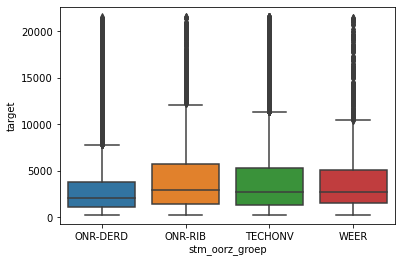

In [39]:
sns.boxplot(x=de_type["stm_oorz_groep"], y=de_type["target"])

De oorzaak groep lijkt niet veel te zeggen over het targetvariabele.

<AxesSubplot:xlabel='stm_techn_mld', ylabel='target'>

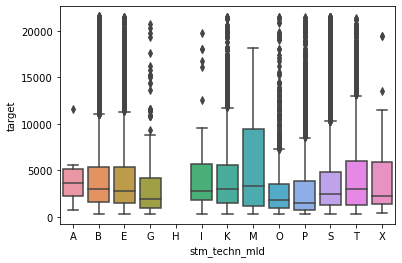

In [40]:
sns.boxplot(x=de_type["stm_techn_mld"], y=de_type["target"])

Hier lijken we al meer mee te kunnen. We dummyencoden deze en voegen hem toe aan het dataframe voor model één.

In [41]:
type_encoded = pd.get_dummies(df["stm_techn_mld"], prefix="Techniekveld")
type_encoded.head(1)

type_encoded.head()

,Techniekveld_A,Techniekveld_B,Techniekveld_E,Techniekveld_G,Techniekveld_H,Techniekveld_I,Techniekveld_K,Techniekveld_M,Techniekveld_O,Techniekveld_P,Techniekveld_S,Techniekveld_T,Techniekveld_X
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
m1_df = m1_df.merge(type_encoded, left_index=True, right_index=True)
m1_df

,Target,Tijdstip,Dag,Techniekveld_A,Techniekveld_B,Techniekveld_E,Techniekveld_G,Techniekveld_H,Techniekveld_I,Techniekveld_K,Techniekveld_M,Techniekveld_O,Techniekveld_P,Techniekveld_S,Techniekveld_T,Techniekveld_X
0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,32400.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,45300.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,60000.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,81000.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898521,1440.0,29160.0,309.0,0,0,0,0,0,0,0,0,0,0,0,0,0
898522,2160.0,33660.0,309.0,0,0,0,0,0,0,0,0,0,0,1,0,0
898523,2160.0,33660.0,309.0,0,0,0,0,0,0,0,0,0,0,1,0,0
898524,1740.0,51317.0,233.0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h2>Prognose aannemer.</h2>

Hoewel uit de interviews blijkt dat de prognose van de aannemer over de duur van functieherstel waarschijnlijk pessimistisch is, zal deze waarschijnlijk toch wel veel zeggen over de daadwerkelijke duur van functieherstel. De aannemer maakt de eerste prognose vrij snel nadat die aankomt, waardoor deze dus ook in het model meegenomen kan worden.

<h3>Data understanding</h3>

In de dataset is een kolom "stm_progfh_in_duur", die in de data dictionairy benoemd staat als "?Duur FHT". Deze kolom is waarschijnlijk een mogelijk attribuut voor de voorspelde duur van functieherstel. Deze gaan we eerst onderzoeken. Ten eerste is een klein inzicht in de data, en het datatype handig.

In [43]:
sample["stm_progfh_in_duur"].head(5)

850794         1060
460790     99999999
408947           35
669975           75
636585     99999999
Name: stm_progfh_in_duur, dtype: object

In [44]:
sample["stm_progfh_in_duur"].dtypes

dtype('O')

Deze kolom word als 'O' geïntrepeteerd door Pandas, hoewel de waardes numeriek lijken. We kunnen deze omzetten naar proper numieriek datatype. Het is interessant om te weten met hoeveel waardes we hierna over blijven die Pandas niet kan intrepeteren, en dus NaN-waardes van maakt.

In [45]:
de_prog_duur = pd.to_numeric(sample["stm_progfh_in_duur"], errors="coerce")
f"De stm_progfh_in_duur kolom bestaat voor {percentage(de_prog_duur.isna().sum(), de_prog_duur.shape[0])}% uit NaN-waardes."

'De stm_progfh_in_duur kolom bestaat voor 0.5497868741166128% uit NaN-waardes.'

Een redelijke hoeveelheid. Om de verdeling te bekijken kunnen we NaN-waardes veilig verwijderen.

In [46]:
de_prog_duur = de_prog_duur.dropna()
de_prog_duur.head(5)

850794        1060.0
460790    99999999.0
408947          35.0
669975          75.0
636585    99999999.0
Name: stm_progfh_in_duur, dtype: float64

<AxesSubplot:>

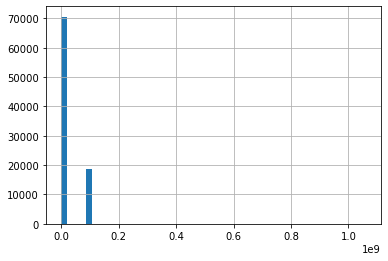

In [47]:
de_prog_duur.hist(bins=50)

Het histogram bij dit variabele is redelijk opvallend. Het inspecteren van de data bleek eerder uit dat deze veel numerieke waardes boven de 1 bevat. Toch zitten deze niet in het histogram. Mogelijk word het creeeren van het histogram verstoord door veel extreme hoge/lage waardes. Dit is wel interessant om te onderzoeken.

In [48]:
f"De stm_progfh_in_duur kolom bestaat voor {percentage((de_prog_duur == 0.0).sum(), de_prog_duur.shape[0])}% uit 0.0."

'De stm_progfh_in_duur kolom bestaat voor 17.375977797423875% uit 0.0.'

Ook leek er een absurd hoge waarde te zijn die vaak ingevuld is, als onechte waarde. Deze kunnen we ook onderzoeken.

In [49]:
f"De stm_progfh_in_duur kolom bestaat voor {percentage((de_prog_duur == 99999999.0).sum(), de_prog_duur.shape[0])}% uit de waarde 99999999."

'De stm_progfh_in_duur kolom bestaat voor 21.03425508342752% uit de waarde 99999999.'

De betekenis van de prognoseduur is ook niet helemaal duidelijk uit de gegeven informatie. Is deze duur van het moment dat de aannemer aankomt, en deze prognose maakt, tot het moment van functieherstel? Of dit vanaf het moment dat de storing begint? Om dit te onderzoeken hebben we ook de datum en het tijdstip waarop de prognose van functieherstel valt in de dataset. Hier kunnen we een apart variabele van maken.

In [50]:
de_prog_moment = sample["stm_progfh_in_datum"] + " " + sample["stm_progfh_in_tijd"]
de_prog_moment = pd.to_datetime(de_prog_moment, errors="coerce")
de_prog_moment.head(2)

850794   2017-11-10 16:00:00
460790                   NaT
dtype: datetime64[ns]

Om vast te stellen of dit variabele inderdaad gelijk is aan dezelfde periode die we afdekken met ons targetvariabele, kunnen we het moment van prognose nemen, en hier het moment dat de aannemer aankomt van aftrekken. We kunnen volgens uit de dataset ook het tijdstip van aankomen van de aannemer halen, en hier vervolgens een variabele voor prognoseduur vanaf het moment dat de aannemer aankomt van maken.

In [51]:
de_prog_aankomst_aann = pd.to_datetime(sample["stm_aanntpl_ddt"], errors="coerce")
de_prog_aankomst_aann.shape

(89853,)

In [52]:
de_prog_duur_2 = (de_prog_moment - de_prog_aankomst_aann).dt.total_seconds()

In [53]:
de_prog_duur_2.shape

(89853,)

Van de_prog_duur_2 weten we dat dit in seconden is gemeten. Van de_prog_duur weten we dat niet zeker. Het is wel interessant om te kijken of deze 2 gelijk aan elkaar zijn, omdat de_prog_duur anders waarschijnlijk niet het beste featurevariabele is wat betreft businessdoelstelling. We nemen een foutmarge van 2 minuten met het vergelijken van de 2 tabellen, want als dit verschil er tussen zit, zouden ze nog steeds hetzelfde kunnen betekenen, met kleine notatiefouten.

In [54]:
de_prog_gelijk_in_seconden = ((np.abs(de_prog_duur_2 - de_prog_duur)) < 120).sum()
f"Wanneer je de tabellen als seconden behandeld, is {percentage(de_prog_gelijk_in_seconden, de_prog_duur_2.shape[0])}% van de kolommen (bijna) gelijk."

'Wanneer je de tabellen als seconden behandeld, is 3.5391138860138227% van de kolommen (bijna) gelijk.'

Dit is duidelijk niet genoeg, dus we kunnen ook kijken of de prognose duur kolom in minuten is gemeten, en dan dezelfde vergelijking doen.

In [55]:
de_prog_duur_2_min = convert_timeunit(de_prog_duur_2, TimeUnit.second, TimeUnit.minute)

de_prog_gelijk_in_minuten = ((np.abs(de_prog_duur_2_min - de_prog_duur)) < 2).sum()
f"Wanneer je de tabellen als minuten behandeld, is {percentage(de_prog_gelijk_in_minuten, de_prog_duur_2.shape[0])}% van de kolommen (bijna) gelijk."

'Wanneer je de tabellen als minuten behandeld, is 50.91204522943029% van de kolommen (bijna) gelijk.'

Hoewel zonder de NaN waardes, dit inderdaad de betekenis van de kolom lijkt te zijn, is de veiligere aanpak die meer correcte waardes in stand houd, de zelf gecreeërde kolom.

We kunnen nu ook naar de waardes in deze kolom kijken. Hiervoor verwijderen we de NaN waardes.

In [56]:
de_prog_duur_2 = de_prog_duur_2.dropna()
de_prog_duur_2.shape

(57090,)

Om meer inzicht in deze gegevens te krijgen, is het ook noodzakelijk de outliers te verwijderen. Hiervoor gebruiken we dezelfde logica als bij het targetvariabele.

In [57]:
(de_prog_duur_2 < convert_timeunit(6, TimeUnit.hour, TimeUnit.second)).sum()

52348

In [58]:
(de_prog_duur_2 > convert_timeunit(5, TimeUnit.minute, TimeUnit.second)).sum()

49917

In [59]:
boven_5_min = de_prog_duur_2 > convert_timeunit(5, TimeUnit.minute, TimeUnit.second)
onder_6_uur = de_prog_duur_2 < convert_timeunit(6, TimeUnit.hour, TimeUnit.second)

de_prog_duur_2 = de_prog_duur_2.loc[boven_5_min & onder_6_uur]  # Gemeten in seconden.

de_prog_duur_2.shape

(45175,)

<AxesSubplot:>

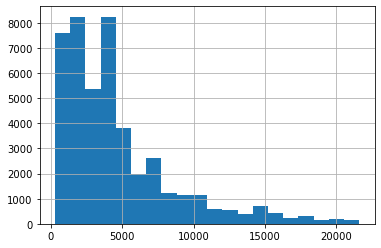

In [60]:
de_prog_duur_2.hist(bins=20)

Dit variabele waarschijnlijk heeft een redelijk gelijke exponentiële verdeling als ons targetvariabele. Zouden deze dan ook correleren?

In [61]:
de_prog_duur_2.shape

(45175,)

In [62]:
de_prog_corr_matrix = pd.DataFrame({"Target": target,
                                    "Prognose": de_prog_duur_2}).dropna()
de_prog_corr_matrix.corr()

,Target,Prognose
Target,1.000000,0.777248
Prognose,0.777248,1.000000


Deze 2 variabele correleren sterk. Dit is dan visueel waarschijnlijk ook te zien.

Text(0.5, 1.0, 'Prognose tegenover target.')

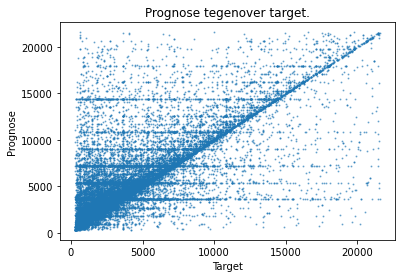

In [63]:
plt.scatter(de_prog_corr_matrix["Target"], de_prog_corr_matrix["Prognose"], s=1, alpha=0.5)
plt.xlabel("Target")
plt.ylabel("Prognose")
plt.title("Prognose tegenover target.")

Hiermee concluderen we dat dit een goed featurevariabele is, welke goed in een model gebruikt kan worden.

<h3>Data preperation</h3>

Nu dit featurevariabele is vastgesteld, blijft er alleen over deze goed te engineeren voor de hele dataset, en dit aan het dataframe voor het model toe te voegen.

In [64]:
progfh_formatted = df["stm_progfh_in_datum"] + " " + df["stm_progfh_in_tijd"]
df["stm_progfh_as_pddt"] = pd.to_datetime(progfh_formatted, errors="coerce")

In [65]:
prognose = (df["stm_progfh_as_pddt"] - df["stm_aanntpl_ddt_as_pddt"]).dt.total_seconds()
m1_df.head(2)

,Target,Tijdstip,Dag,Techniekveld_A,Techniekveld_B,Techniekveld_E,Techniekveld_G,Techniekveld_H,Techniekveld_I,Techniekveld_K,Techniekveld_M,Techniekveld_O,Techniekveld_P,Techniekveld_S,Techniekveld_T,Techniekveld_X
0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,32400.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
prognose.shape

(898526,)

In [67]:
boven_5_min = prognose > convert_timeunit(5, TimeUnit.minute, TimeUnit.second)
onder_6_uur = prognose < convert_timeunit(6, TimeUnit.hour, TimeUnit.second)

prognose = prognose.loc[boven_5_min & onder_6_uur]  # Gemeten in seconden.

target.head(5)

32099    2400.0
60682     900.0
60683     900.0
84560     319.0
84561     319.0
Name: fh_min_aanntpl, dtype: float64

In [68]:
prognose.shape

(451227,)

In [69]:
m1_df["Prognose"] = prognose

<AxesSubplot:>

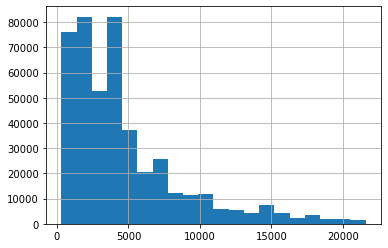

In [70]:
m1_df["Prognose"].hist(bins=20)

<h2>Locatie storing</h2>

<h3>Data exploration</h2>

Uit ons businessonderzoek blijkt dat een idee van waar een storing gebeurt ook iets kan zeggen over de duur tot functieherstel. Een aantal kolommen zouden hier mogelijk voor gebruikt kunnen worden. Bijvoorbeeld "stm_geo_mld", "stm_contractgeb_mld" of "stm_geo_gst". Omdat één gebied niet persé volgordelijk zijn, kunnen we deze variabelen als nominaal beschouwen. Omdat een variabele met heel veel permutaties waarschijnlijk tot te veel dimensies voor nuttige modellen zou lijden, is het handig een variabele te kiezen met niet al te veel permutaties. Hier kunnen we naar kijken.

In [71]:
df[["stm_geo_mld", "stm_geo_gst", "stm_contractgeb_mld"]].nunique()

stm_geo_mld            806
stm_geo_gst            873
stm_contractgeb_mld     57
dtype: int64

stm_contractgeb_mld heeft niet al te veel permutaties. Ook hebben we van ProRail hier de betekenissen van gekregen.

In [72]:
sample["stm_contractgeb_mld"].head(5)

850794     4.0
460790    63.0
408947    25.0
669975     NaN
636585    58.0
Name: stm_contractgeb_mld, dtype: float64

In [73]:
contractgebied_betekenissen = pd.read_excel("Contractgebiedcodes.xlsx")
contractgebied_betekenissen

,Contractgebied,Code
0,Rijn en Gouwe,1
1,Rijn en Gouwe,81
2,Den Haag,2
3,Rotterdam,3
4,Zee - Zevenaar,4
5,Zee - Zevenaar,71
6,Dordrecht,5
7,Hollands Noorderkwartier,6
8,Hollands Noorderkwartier,7
9,Haarlem,8


Elk van deze categoriën staat voor een bepaald contractgebied, bijvoorbeeld "Utrecht" of "overig". Uit de betekenissen weten we dat veel van deze gebiedscodes voor dezelfde gebieden staan.

<h3>Data preperation.</h3>

Om de permutaties te verminderen kunnen we met een replace operatie alle duplicaatbetekenissen naar 1 categorie veranderen. We kunnen alle codes met dezelfde betekenis naar één code veranderen.

In [74]:
contractgebied = df["stm_contractgeb_mld"]
contractgebied = contractgebied.replace({81.0: 1.0,
                                         71.0: 4.0,
                                         7.0: 6.0,
                                         11.0: 10.0,
                                         16.0: 12.0,
                                         14.0: 13.0,
                                         15.0: 13.0,
                                         18.0: 19.0,
                                         20.0: 23.0,
                                         21.0: 22.0,
                                         24.0: 27.0,
                                         28.0: 30.0,
                                         29.0: 31.0,
                                         33.0: 31.0,
                                         34.0: 35.0,
                                         36.0: 37.0,
                                         63.0: 0.0,
                                         61.0: 0.0,
                                         51.0: 0.0,
                                         52.0: 0.0,
                                         60.0: 0.0,
                                         58.0: 0.0,
                                         59.0: 0.0,
                                         70.0: 0.0,
                                         25.0: 0.0,
                                         26.0: 0.0})


En voor het volledige kan dit ook nog even naar een categorie datatype veranderd worden.

In [75]:
contractgebied = contractgebied.astype("category")

We kunnen dit met een dummyencoding bruikbaar maken voor een model.

In [76]:
loc_encoded = pd.get_dummies(contractgebied, prefix="Contractgebied")

En dit kan vervolgens toegevoegd worden aan het dataframe voor gebruik in een model.

In [77]:
m1_df = m1_df.merge(loc_encoded, left_index=True, right_index=True)

<h2>Modelling.</h2>

Nu deze featurevariabelen zijn vastgesteld, kunnen we 2 DataFrames voor 2 soorten modellen maken.

Omdat we hebben vastgesteld dat de prognose van de aannemer het meest belovende featurevariabele is, zullen we modellen met alleen dit als featurevariabele maken. Hiernaast zullen we op basis van alle enigzins mogelijk nuttige variabelen nog modellen maken.

Voor het overzicht nog even de lineare correlaties van alle variabelen met de target:

In [78]:
m1_df.corr()["Target"]

Target                 1.000000
Tijdstip              -0.044596
Dag                   -0.000566
Techniekveld_A         0.006920
Techniekveld_B         0.050600
Techniekveld_E         0.024054
Techniekveld_G        -0.007816
Techniekveld_H              NaN
Techniekveld_I         0.008864
Techniekveld_K         0.022999
Techniekveld_M         0.015349
Techniekveld_O        -0.065544
Techniekveld_P        -0.053116
Techniekveld_S        -0.021111
Techniekveld_T         0.033410
Techniekveld_X         0.007195
Prognose               0.779429
Contractgebied_0.0    -0.013150
Contractgebied_1.0     0.001050
Contractgebied_2.0     0.003534
Contractgebied_3.0     0.005292
Contractgebied_4.0     0.033447
Contractgebied_5.0     0.017172
Contractgebied_6.0     0.004314
Contractgebied_8.0     0.021967
Contractgebied_9.0     0.000071
Contractgebied_10.0    0.007473
Contractgebied_12.0   -0.013317
Contractgebied_13.0    0.038916
Contractgebied_17.0   -0.006750
Contractgebied_19.0    0.014968
Contract

<h3>Alleen prognose</h3>

We maken een apart dataframe voor de alleen-prognose modellen.

In [79]:
m1_df_prog = m1_df[["Prognose", "Target"]].dropna()

Eerder hebben we vastgesteld dat er een enorm sterk linear verband tussen de prognose en de target zit. We kunnen op basis hiervan een linear regressiemodel proberen te maken. Er vallen hier geen hyperparameters aan te passen.

In [80]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(m1_df_prog["Prognose"].values.reshape(-1, 1), m1_df_prog["Target"], random_state=0)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
lin_RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)
f"In seconden heeft de lineare regressie op basis van alleen prognose een RMSE van {lin_RMSE}."

'In seconden heeft de lineare regressie op basis van alleen prognose een RMSE van 2329.5169250228932.'

In [81]:
f"Ofwel {convert_timeunit(lin_RMSE, TimeUnit.second, TimeUnit.minute)} minuten."

'Ofwel 38.82528208371489 minuten.'

Dit is al een behoorlijke verbetering over de baseline. We slaan deze op in het models dataframe voor overzicht.

In [82]:
models = models.append({"Title": "Linear regression with prognose only",
                        "Model": reg,
                        "RMSE": lin_RMSE},
                       ignore_index=True)
models

,Title,Model,RMSE
0,BaseLine model with mean strategy,DummyRegressor(),3904.892580
1,Linear regression with prognose only,LinearRegression(),2329.516925


<h3>Meerdere features</h3>

We hebben een aantal meer features waarmee we kunnen proberen de eerder behaalde score te verbeteren.

We hebben in het selecteren van de featurevariabelen gezorgd dat er niet al te veel rijen met NaN-waardes zijn, dus deze kunnen we veilig verwijderen.

In [83]:
m1_df = m1_df.dropna()

En we delen de Feature/Targetvariabelen weer op in een train en test dataset.

In [84]:
X_m1 = m1_df.drop(columns="Target")
y_m1 = m1_df["Target"]

In [85]:
X_m1_train, X_m1_test, y_m1_train, y_m1_test = model_selection.train_test_split(X_m1, y_m1, random_state=0)

Een goed eerste regressiemodel om te proberen is weer een lineare regressie. We weten dat de prognose een sterk linear verband heeft met het targetvariabele, dus dit is een goed beginpunt.

In [86]:
m1 = linear_model.LinearRegression()
m1.fit(X_m1_train, y_m1_train)
m1_lin_rmse = metrics.mean_squared_error(y_m1_test, m1.predict(X_m1_test), squared=False)
f"Lineare regressie op basis van alle featurevariabelen heeft een RMSE van {convert_timeunit(m1_lin_rmse, TimeUnit.second, TimeUnit.minute)} minuten"

'Lineare regressie op basis van alle featurevariabelen heeft een RMSE van 38.533605315113235 minuten'

Dit model doet het miniscuul beter dan het vorige model. Toch slaan we deze voor het overzicht op in het models dataframe.

In [87]:
models = models.append({"Title": "Linear regression with all features",
                        "Model": m1,
                        "RMSE": m1_lin_rmse},
                       ignore_index=True)
models

,Title,Model,RMSE
0,BaseLine model with mean strategy,DummyRegressor(),3904.892580
1,Linear regression with prognose only,LinearRegression(),2329.516925
2,Linear regression with all features,LinearRegression(),2312.016319


Een interessant volgend regressiemodel om te proberen is polynome regressie. Features als tijdstip op de dag of dag in het jaar zullen eerder een complexere correlatie met het targetvariabele hebben dan een lineare. We kunnen een polynome regressie die maximaal tot de 2e macht gaat proberen, om te kijken of dit een betere score geeft.

Op het moment is een hogere-orde polynoom niet mogelijk, omdat dit te veel werkgeheugen inneemt.

In [88]:
degree = 2

polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

polyreg.fit(X_m1_train,y_m1_train)
polyreg_rmse = metrics.mean_squared_error(y_m1_test, polyreg.predict(X_m1_test), squared=False)
f"2e-machts polynome regressie op basis van alle featurevariabelen heeft een RMSE van {convert_timeunit(polyreg_rmse, TimeUnit.second, TimeUnit.minute)} minuten."

'2e-machts polynome regressie op basis van alle featurevariabelen heeft een RMSE van 37.64460990265023 minuten.'

De score van dit model is miniscuul beter in vergelijking met de lineare regressie. Ook voegen we dit model aan het modelsvariabele toe.

In [89]:
models = models.append({"Title": "Linear regression with all features",
                        "Model": polyreg,
                        "RMSE": polyreg_rmse},
                       ignore_index=True)
models

,Title,Model,RMSE
0,BaseLine model with mean strategy,DummyRegressor(),3904.892580
1,Linear regression with prognose only,LinearRegression(),2329.516925
2,Linear regression with all features,LinearRegression(),2312.016319
3,Linear regression with all features,"(PolynomialFeatures(), LinearRegression())",2258.676594


Hoewel er geen overduidelijke reden is waarom een Decision Tree Regressor beter zou werken, kunnen dit soort dingen toch onverwacht soms gebeuren. We proberen een menig aantal verschillende maximale dieptes als hypterparameter, en plotten de score op zowel de testset als de trainset van deze. De score op de testset is hier leidend voor modelscore, maar de score op de trainset kan een gevoel voor overfitting geven.

Text(0.5, 1.0, 'Max depth setting vs. RMSE.')

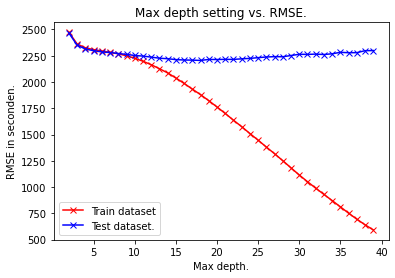

In [90]:
max_depths = np.arange(2, 40)                                                                                                          # Generate max depths to create tree at.

m1_trees = np.vectorize(lambda mx: tree.DecisionTreeRegressor(max_depth=mx))(max_depths)                                               # Create trees
m1_trees = np.vectorize(lambda m: m.fit(X_m1_train, y_m1_train))(m1_trees)                                                             # Fit trees
m1_trees_train_score = np.vectorize(lambda m: metrics.mean_squared_error(y_m1_train, m.predict(X_m1_train), squared=False))(m1_trees)  # Score trees on train set.
m1_trees_test_score = np.vectorize(lambda m: metrics.mean_squared_error(y_m1_test, m.predict(X_m1_test), squared=False))(m1_trees)     # Score trees on test set.

fig, ax = plt.subplots()
ax.plot(max_depths, m1_trees_train_score, "rx-")
ax.plot(max_depths, m1_trees_test_score, "bx-")
ax.set_ylabel("RMSE in seconden.")
ax.set_xlabel("Max depth.")
ax.legend(["Train dataset", "Test dataset."])
ax.set_title("Max depth setting vs. RMSE.")

Een max depth van 15 lijkt een goede RMSE te hebben. Deze slaan we ook op.

In [91]:
models = models.append({"Title": "Decision tree regression with all features",
                        "Model": m1_trees[13],
                        "RMSE": m1_trees_test_score[13]},
                       ignore_index=True)
models

,Title,Model,RMSE
0,BaseLine model with mean strategy,DummyRegressor(),3904.892580
1,Linear regression with prognose only,LinearRegression(),2329.516925
2,Linear regression with all features,LinearRegression(),2312.016319
3,Linear regression with all features,"(PolynomialFeatures(), LinearRegression())",2258.676594
4,Decision tree regression with all features,DecisionTreeRegressor(max_depth=15),2212.466061


In [93]:
f"Een decision tree regressor met een max depth van 15 heeft een RMSE van {convert_timeunit(models.loc[4, 'RMSE'], TimeUnit.second, TimeUnit.minute)}."

'Een decision tree regressor met een max depth van 15 heeft een RMSE van 36.87443434244716.'

Tot nu toe heeft dit model te beste score, hoewel het weer een miniscule verbetering is.

<h2>Evaluatie</h2>

Hoewel het geen ML-model is, kunnen we de prognose van de aannemer ook als een soort model/voorspelling behandelen, en hier de RMSE van uitrekenen.

In [94]:
prog_rmse = metrics.mean_squared_error(m1_df['Target'], m1_df['Prognose'], squared=False)
f"De prognose van de aannemer heeft een RMSE van {convert_timeunit(prog_rmse, TimeUnit.second, TimeUnit.minute)} minuten."

'De prognose van de aannemer heeft een RMSE van 45.62619626079762 minuten.'

Welke vervolgens dus ook in het models variabele opgeslagen kan, voor een definitief overzicht.

In [95]:
models = models.append({"Title": "Prognose aannemer",
                        "Model": None,
                        "RMSE": prog_rmse},
                       ignore_index=True)
models

,Title,Model,RMSE
0,BaseLine model with mean strategy,DummyRegressor(),3904.892580
1,Linear regression with prognose only,LinearRegression(),2329.516925
2,Linear regression with all features,LinearRegression(),2312.016319
3,Linear regression with all features,"(PolynomialFeatures(), LinearRegression())",2258.676594
4,Decision tree regression with all features,DecisionTreeRegressor(max_depth=15),2212.466061
5,Prognose aannemer,None,2737.571776


Om goed de gecreeërde modellen te kunnen evalueren, is het handig de doelstelling van dit onderzoek terug te halen.

<b>Het doel is om betere prognoses te doen dan de aannemer.</b>.

De prognose van de aannemer heeft een RMSE van ongeveer 45 minuten.
We hebben deze echter, met een lineare regressie gebaseerd op alleen de prognose van de aannemer, gereduceerd naar ongeveer 38 minuten. Hiermee hebben we ontdekt dat hoewel de aannemer vaak pessimistisch is, zij redelijk voorspelbaar pessimischtisch is, waardoor hier makkelijk op verbeterd kan op een redelijk transparante wijze.

Ook hebben we ontdekt dat met het toevoegen van een aantal variabelen:

<ol>
<li>Tijdstip op de dag</li>
<li>Dag in het jaar</li>
<li>Contractgebied</li>
<li>Techniekveld</li>
</ol>

Dit nog op miniscule wijze verbeterd kan, naar een RMSE van ongeveer 36 minuten.

Omdat dit zo weinig oplevert, en het de transparantie verminderd, kiezen wij ervoor het lineare regressiemodel naar productie te brengen.

<h2>Deployment</h2>

In [96]:
#filename = 'linear_reg.pkl'
#pickle.dump(reg, open(filename, 'wb'))